In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
from timm import create_model

cihaz = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Cihaz: {cihaz}')

model = create_model('vit_base_patch16_224', pretrained=False)
model.head = nn.Linear(model.head.in_features, 10)
model = model.to(cihaz)

model_yolu = '/content/drive/My Drive/colabmodels/vitmodelson.pth'
kayit_dict = torch.load(model_yolu)

model.load_state_dict(kayit_dict['model_state_dict'])

print('ViT modeli başarıyla yüklendi ve hazır.')


Cihaz: cuda


<ipython-input-3-3824091a3c27>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  kayit_dict = torch.load(model_yolu)


ViT modeli başarıyla yüklendi ve hazır.


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

testVeriSeti = datasets.ImageFolder('/content/drive/My Drive/YapayZekaRessam/test', transform=transform)
testYukleyici = DataLoader(testVeriSeti, batch_size=32, shuffle=False, num_workers=4)


sinifAdlari = testVeriSeti.classes
print('Test verileri hazırlandı.')

Test verileri hazırlandı.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

In [ ]:
gercek = []
tahmin = []

model.eval()
with torch.no_grad():
    for inputs, labels in testYukleyici:
        inputs, labels = inputs.to(cihaz), labels.to(cihaz)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        gercek.extend(labels.cpu().numpy())
        tahmin.extend(predicted.cpu().numpy())

confMatrix = confusion_matrix(gercek, tahmin)

def hesaplaSpecificity(confMatrix):
    specificitySinifBasina = []
    for i in range(len(confMatrix)):
        tn = confMatrix.sum() - (confMatrix[i, :].sum() + confMatrix[:, i].sum() - confMatrix[i, i])
        fp = confMatrix[:, i].sum() - confMatrix[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificitySinifBasina.append(specificity)
    return np.mean(specificitySinifBasina)

specificity = hesaplaSpecificity(confMatrix)

accuracy = accuracy_score(gercek, tahmin)
precision = precision_score(gercek, tahmin, average='weighted')
recall = recall_score(gercek, tahmin, average='weighted')
fScore = f1_score(gercek, tahmin, average='weighted')

olasilik = []
with torch.no_grad():
    for inputs, _ in testYukleyici:
        inputs = inputs.to(cihaz)
        outputs = model(inputs)
        olasiliklar = torch.softmax(outputs, dim=1)
        olasilik.extend(olasiliklar.cpu().numpy())

gercekOneHot = np.eye(len(np.unique(gercek)))[gercek]
auc = roc_auc_score(gercekOneHot, np.array(olasilik), average='weighted', multi_class='ovr')

print(f"Accuracy: %{accuracy * 100:.2f}")
print(f"Precision: %{precision * 100:.2f}")
print(f"Recall: %{recall * 100:.2f}")
print(f"Specificity: %{specificity * 100:.2f}")
print(f"F-Score: %{fScore * 100:.2f}")
print(f"AUC: %{auc * 100:.2f}")

Accuracy: %95.09
Precision: %95.24
Recall: %95.09
Specificity: %99.45
F-Score: %95.10
AUC: %99.85


In [ ]:
import time

def cikarimHesap(model, testYukleyici, cihaz):
    model.eval()
    baslangicZamani = time.time()

    with torch.no_grad():
        for gorseller, _ in testYukleyici:
            gorseller = gorseller.to(cihaz)
            cikti = model(gorseller)

    bitisZamani = time.time()
    cikarmaZamani = bitisZamani - baslangicZamani
    return cikarmaZamani

cikarmaZamani = cikarimHesap(model, testYukleyici, cihaz)
print(f'Çıkarım Zamanı: {cikarmaZamani:.2f} saniye')

Çıkarım Zamanı: 5.36 saniye


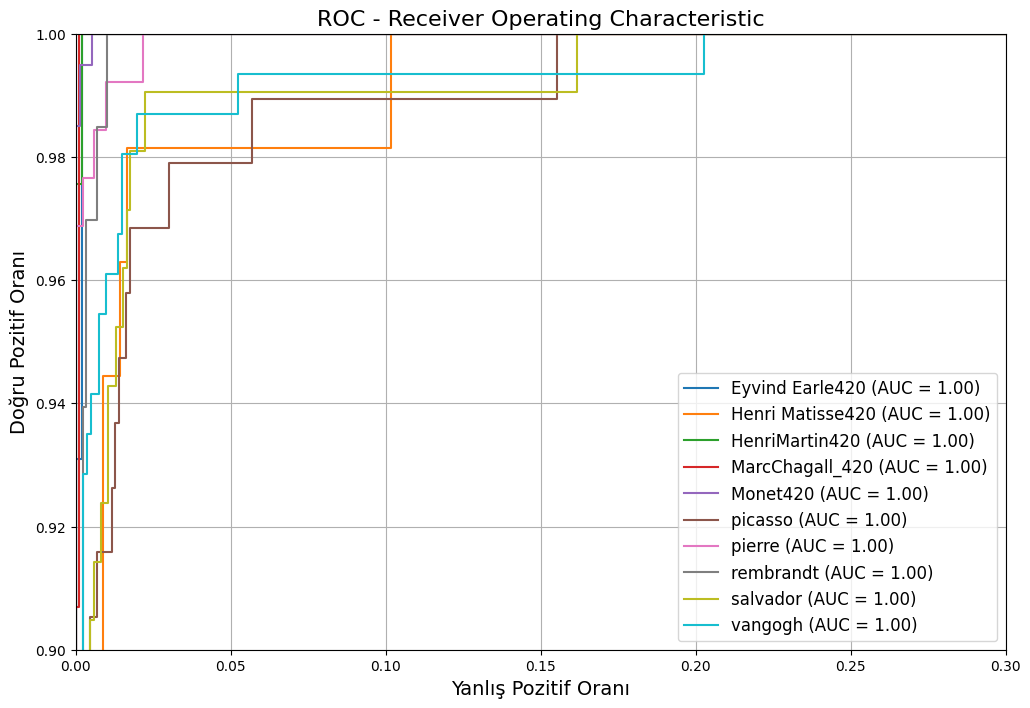

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def ROCEgrisi(gercek, olasilik, sinifAdlari):
    plt.figure(figsize=(12, 8))

    for i, sinifAdi in enumerate(sinifAdlari):
        fpr, tpr, _ = roc_curve(gercek[:, i], olasilik[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{sinifAdi} (AUC = {roc_auc:.2f})')

    plt.xlim([0.0, 0.3])
    plt.ylim([0.9, 1.0])
    plt.xlabel('Yanlış Pozitif Oranı', fontsize=14)
    plt.ylabel('Doğru Pozitif Oranı', fontsize=14)
    plt.title('ROC - Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc='lower right', prop={'size': 12})
    plt.grid(True)
    plt.show()

gercek = []
olasilik = []

model.eval()
with torch.no_grad():
    for inputs, labels in testYukleyici:
        inputs, labels = inputs.to(cihaz), labels.to(cihaz)
        outputs = model(inputs)
        olasiliklar = torch.softmax(outputs, dim=1)

        gercek.extend(labels.cpu().numpy())
        olasilik.extend(olasiliklar.cpu().numpy())

gercekOneHot = np.eye(len(np.unique(gercek)))[gercek]
olasilik = np.array(olasilik)

sinifAdlari = testVeriSeti.classes

ROCEgrisi(gercekOneHot, olasilik, sinifAdlari)

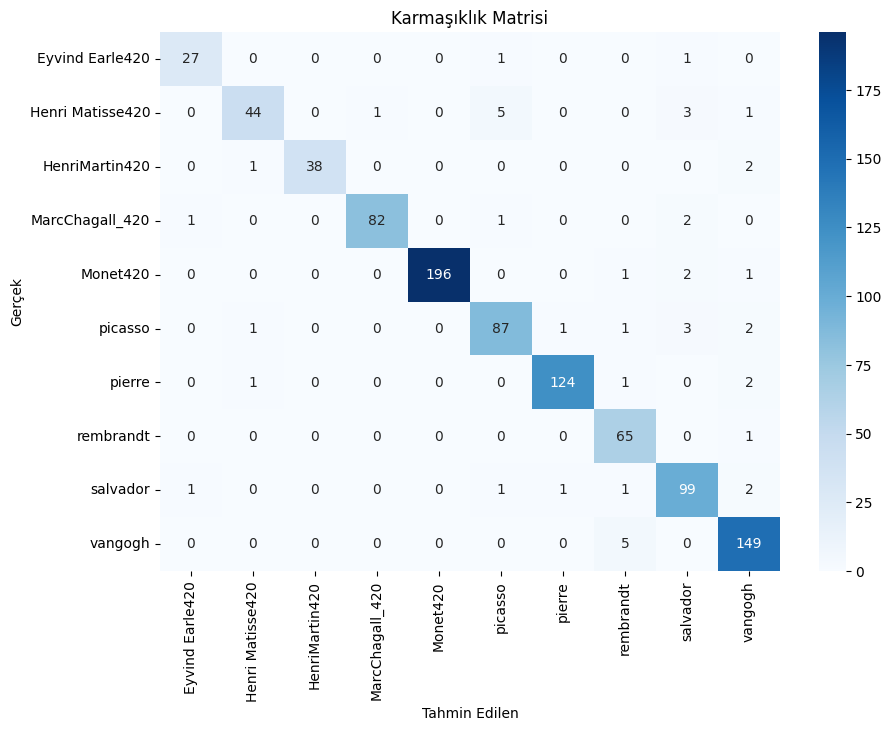

In [ ]:
import seaborn as sns

def karmasiklikMatris(gercek, tahmin, sinifAdlari):
    confMatrix = confusion_matrix(gercek, tahmin)

    plt.figure(figsize=(10, 7))
    sns.heatmap(confMatrix, annot=True, fmt='d', cmap='Blues', xticklabels=sinifAdlari, yticklabels=sinifAdlari)
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.title('Karmaşıklık Matrisi')
    plt.show()

gercek = []
tahmin = []

model.eval()
with torch.no_grad():
    for inputs, labels in testYukleyici:
        inputs, labels = inputs.to(cihaz), labels.to(cihaz)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        gercek.extend(labels.cpu().numpy())
        tahmin.extend(predicted.cpu().numpy())

sinifAdlari = testVeriSeti.classes

karmasiklikMatris(gercek, tahmin, sinifAdlari)